In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd

In [30]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [32]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [33]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [34]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

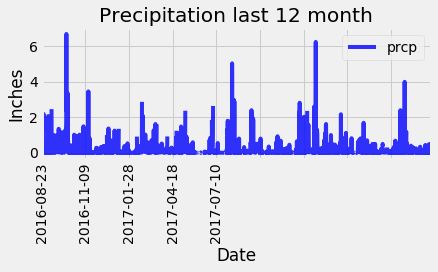

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
first_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
date_last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_date = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_last_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_date)
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("date")
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation last 12 month", color='blue', alpha=0.8)
plt.legend(loc="upper right")
plt.xticks(rotation="vertical")
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.savefig("Images/Precipitation_last_12_months_plot.png")
plt.show()

In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [39]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(Measurement.station).distinct().count()
stations_available

9

In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [41]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == active_stations[0][0]).all()
print(f"Low temperature for station {active_stations[0][0]} is {temp[0][0]}")
print(f"High temperature for station {active_stations[0][0]} is {temp[0][1]}")
print(f"Average temperature for station {active_stations[0][0]} is {round(temp[0][2], 2)}")

Low temperature for station USC00519281 is 54.0
High temperature for station USC00519281 is 85.0
Average temperature for station USC00519281 is 71.66


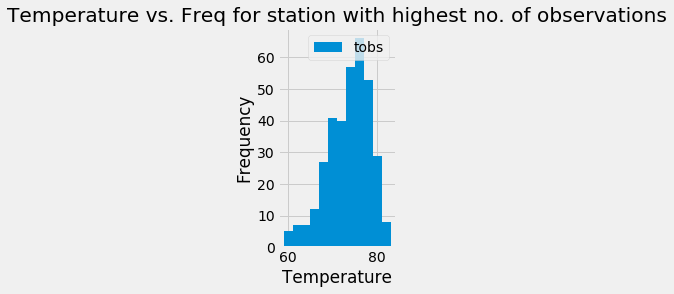

In [42]:
# Choose the station with the highest number of temperature observations.
station_most_temp = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
#station_most_temp[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obsv = session.query(Measurement.tobs).filter(Measurement.date >= date_last_year).\
            filter(Measurement.station == station_most_temp[0]).all()
temp_obsv_pd = pd.DataFrame(temp_obsv)
temp_obsv_pd.plot.hist(bins=12, title="Temperature vs. Freq for station with highest no. of observations")
plt.tight_layout()
plt.xlabel("Temperature")
plt.savefig("Images/station_histogram_plot.png")
plt.show()

## Bonus Challenge Assignment

In [43]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [44]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps('2016-07-01', '2016-07-05')
trip_data

[(71.0, 77.22222222222223, 82.0)]

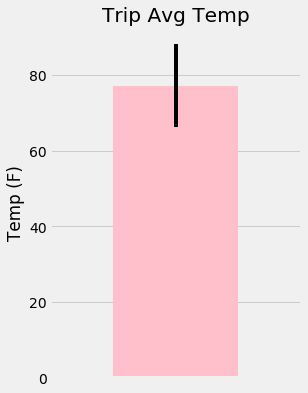

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_data, columns=["TMIN", "TAVE", "TMAX"])
trip_df.plot.bar(y='TAVE', yerr=(trip_df['TMAX'] - trip_df['TMIN']), title="Trip Avg Temp", color='pink', legend=None, figsize = (4,6))
plt.xticks(np.arange(1,1.0))
plt.ylabel("Temp (F)")
plt.savefig("Images/temperature_plot.png")
plt.show()

In [46]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [47]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [48]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-07-01'
end_date = '2017-07-05'

# Use the start and end date to create a range of dates
date_range = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
             group_by(Measurement.date).all()
trip_dates = [date[0] for date in date_range]

# Stip off the year and save a list of %m-%d strings
date_mth_day=[]
for date in date_range:
    date = date[0].split("-")
    date_mth_day.append(date[1]+"-"+date[2])
normals = []
# Loop through the list of %m-%d strings and calculate the normals for each date
for mt_day in date_mth_day:
    normals.append(daily_normals(mt_day)[0])


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals, columns=["TMIN", "TAVG", "TMAX"])
normal_df['Date'] = trip_dates
normal_df.set_index('Date', inplace=True)
normal_df.head()

,TMIN,TAVG,TMAX
Date,,,
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0


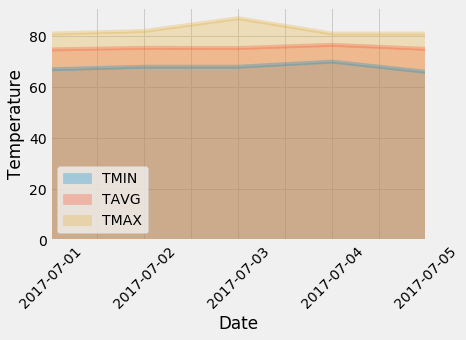

In [49]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot(kind="area", stacked=False, alpha=.3)
plt.ylabel("Temperature")
plt.xticks(rotation=45)
plt.savefig("Images/daily_normals_plot.png")
plt.show()